# Desarrollo por Joaquin Zepeda V.

Tarea 3 EL7008 - Detección de personas usando Adaboost y características de tipo Haar.

# Subimos las imagenes a google colab y luego las extraemos

Se debe subir la archivo imagenes_tarea4_2022.zip y luego se ejecuta todo.

In [ ]:
!unzip /content/imagenes_tarea4_2022.zip

Archive:  /content/imagenes_tarea4_2022.zip
   creating: car_side/
 extracting: car_side/image_0001.jpg  
  inflating: car_side/image_0002.jpg  
 extracting: car_side/image_0003.jpg  
 extracting: car_side/image_0004.jpg  
 extracting: car_side/image_0005.jpg  
 extracting: car_side/image_0006.jpg  
 extracting: car_side/image_0007.jpg  
 extracting: car_side/image_0008.jpg  
 extracting: car_side/image_0009.jpg  
 extracting: car_side/image_0010.jpg  
 extracting: car_side/image_0011.jpg  
 extracting: car_side/image_0012.jpg  
 extracting: car_side/image_0013.jpg  
 extracting: car_side/image_0014.jpg  
 extracting: car_side/image_0015.jpg  
 extracting: car_side/image_0016.jpg  
 extracting: car_side/image_0017.jpg  
 extracting: car_side/image_0018.jpg  
 extracting: car_side/image_0019.jpg  
 extracting: car_side/image_0020.jpg  
 extracting: car_side/image_0021.jpg  
 extracting: car_side/image_0022.jpg  
 extracting: car_side/image_0023.jpg  
 extracting: car_side/image_0024.jpg

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import cython
import cv2

np.random.seed(42)

In [23]:
"""
1. leer las imágenes de la base de datos: 80% train, 20% test.  Para dividir los datos en
entrenamiento y prueba, se debe utilizar una semilla fija al usar train_test_split( )
Redimensionar las imagenes a 24x24.
Las etiquetas deben ser +1 para las imagenes con perosnas y -1 para las imagenes sin personas.
"""
import glob

def cargarDatos(nombre_carpeta,extension,clase):
    """
    Ejemplo de uso cargarDatos(car_side,"jpg",-1)
    """
    data = []
    path = glob.glob(f"{nombre_carpeta}//*.{extension}")
    if nombre_carpeta == "pedestrian":
        path.sort(key=lambda x: int((x.split(".")[0].split('/')[1]))) # ordena el conjunto de datos para tener resultados reproducibles
    else:
        path.sort(key=lambda x: int((x.split(".")[0].split('/')[1].split("_")[1]))) # ordena el conjunto de datos
    label = []
    for img in path:
        #leemos la imagen en escala de grises
        gray = cv2.imread(img,0)
        gray32 = np.float32(gray)
        out = cv2.resize(gray32, (24,24))
        data.append(out)
        label.append(clase)

    return np.array(data),np.array(label)


#Carga todos los datos de la carpeta "car_side" y le asigna la clase -1
dataCar_side,CSlabel = cargarDatos("car_side","jpg",-1)
text_labels = ["Cars/Chairs","pedestrian"]

#Carga todos los datos de la carpeta "chair" y le asigna la clase -1
dataChair,CL = cargarDatos("chair","jpg",-1)

#Carga todos los datos de la carpeta "pedestrian" y le asigna la clase 1
dataPedestrian,PL = cargarDatos("pedestrian","png",1)

#data no normalizada
data = np.concatenate((dataCar_side,dataChair,dataPedestrian))
labels = np.concatenate((CSlabel,CL,PL))

In [24]:
# Conjuntos de train y test
#random_state = 42 semilla fija para resultados reproducibles.
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle = True, stratify = labels,random_state=42)

In [25]:
print(X_train.shape)
print(X_test.shape)

(296, 24, 24)
(74, 24, 24)


In [26]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [27]:
%%cython

import numpy as np
cimport numpy as np

cpdef np.ndarray[np.float32_t,ndim=2] integral(np.ndarray[np.float32_t,ndim=2] img):
    """
    2. función en Cython que permita calcular la imagen integral, dada una imagen.
    """
    cdef int rows,cols,i,j 
    cdef np.ndarray[np.float32_t, ndim=2] output=np.zeros([img.shape[0], img.shape[1]], dtype = np.float32)
    # tamano de la imagen
    rows = img.shape[0]
    cols = img.shape[1]
    #Como se van guardando los valores en la imagen integral, por construcción
    #se puede realizar con 4 operaciones (usando valores precomputados), de esta
    #manera se evita realizar sumas repetitivas.

    output[0][0] = img[0][0]
    for i in range(rows):
      for j in range(cols): 
          #Casos base
          if i==0:
              output[i][j] = output[i][j-1] + img[i][j]
          elif j==0:
              output[i][j] = output[i-1][j] + img[i][j]
          else:
              output[i][j] = img[i][j]+output[i-1][j]+output[i][j-1]-output[i-1][j-1]
        
    return output

In [28]:
"""
3. Implementar una función que genere parámetros que permitan determinar las máscaras de
las características Haar. Las máscaras se deben parametrizar como: (y1, x1, y2, x2, tipo,
polaridad), donde:
a. (y1,x1) es la esquina superior izquierda de la máscara
b. (y2,x2) es la esquina inferior derecha de la máscara
c. Tipo: número entre 0 y 4, que permite determinar el tipo de máscara
d. Polaridad: +1 (positiva) o –1 (negativa).
Dado que en cada imagen las características de pueden calcular en muchas posibles
posiciones, se recomienda aplicarlas usando el concepto de ventana deslizante usando un
paso de tamaño 3. Además, se recomienda usar sólo 3 valores para los anchos de las
máscaras y 3 valores para los altos. En consecuencia, hay 9 posibles combinaciones de
anchos/altos. En el caso de las máscaras de tipo 0, 1 y 4, los anchos deben ser múltiplos de 4,
mientras que para las características 2 y 3, el ancho debe ser múltiplo de 3. Además, se debe
almacenar la polaridad de cada máscara, la cual puede ser +1 o -1.
"""
import numpy as np
def gen_parameters():
    L = []
    tipos = [   0,          1,      2,          3,      4]
    tipo2y3 = [3,6,9]
    anchos = [[4,8,12], [4,8,12], tipo2y3, tipo2y3,[4,8,12]]
    altos = [[4,8,12], [4,8,12], tipo2y3, tipo2y3,[4,8,12]]
    #generamos los parametros por cada tipo, sus 9 combinaciones
    #y además recorremos con una ventana deslizante de paso 3 con el fin
    #de determinar todas las mascaras que queden dentro de la imagen.
    for tipo in tipos:
            for y1 in range(0,24,3):
                for x1 in range(0,24,3):
                    for A in anchos[tipo]:
                        for B in altos[tipo]:
                            if y1+B<24 and x1+A<24:
                                #agregamos las mascaras en sus 2 polaridades
                                L.append([y1,x1,y1+B,x1+A,tipo,0])
                                L.append([y1,x1,y1+B,x1+A,tipo,1])

    return L


def Haar(img_set,mascaras):
    """
    4. Implementar una función que, dado un conjunto de imágenes y parámetros de máscaras,
    calcule vectores de características. Dichos vectores deben contener todas las características
    tipo Haar determinadas en el punto anterior, para cada imagen.
    
    Por cada imagen, determinamos la imagen integral y luego dependiendo del tipo de la mascara
    se calcula el valor de la mascara aplicada en la imagen según las posiciones que indica la mascara.
    """
    feature_set = []
    for img in img_set:
        features = np.zeros(len(mascaras))
        #determinamos la imagen integral
        I = integral(img)
        for index,mask in enumerate(mascaras):
            #rescatamos los parametros de la mascara
            y1,x1,y2,x2,tipo,p = mask
            A = x2-x1
            B = y2-y1
            
            if tipo==0:
                d = x1+A//2
                features[index]=p*(( I[y2][d]+I[y1][x1]-I[y2][x1]-I[y1][d] )       
                                -( I[y2][x2] + I[y1][d]-I[y2][d]-I[y1][x2]))
            elif tipo==1:
                d = y1+B//2
                features[index]=p*(( I[y2][x2]+I[d][x1]-I[y1][x2]-I[d][x2] )       
                                 -( I[d][x2] + I[y1][x1]-I[d][x1]-I[y1][x2]))
            elif tipo==2:
                d1 = x1+A//3
                d2 = x1+2*A//3
                features[index]=p*(  (I[y2][d1]+I[y1][x1]-I[y1][d1]-I[y2][x1])
                                    - ( I[y2][d2]+I[y1][d1]-I[y1][d2]-I[y2][d1])
                                    + ( I[y2][x2] + I[y1][d2] - I[y2][d2] - I[y1][x2]))
            elif tipo==3:
                d1 = y1+B//3
                d2 = y1+2*B//3
                features[index]=p*( (I[d1][x2] + I[y1][x1] - I[d1][x1] - I[y1][x2])
                                   -(I[d2][x2] + I[d1][x1] - I[d2][x1] - I[d1][x2])
                                   +(I[y2][x2] + I[d2][x1] - I[y2][x1] - I[d2][x2] ))
            else:
                dy = y1+B//2
                dx = x1+A//2
                features[index]=p*( (I[dy][dx] + I[y1][x1] - I[dy][x1] - I[y1][dx])
                                - (  I[dy][x2] + I[y1][dx] - I[dy][dx] - I[y1][x2])
                                - (  I[y2][dx] + I[dy][x1] - I[y2][x1] - I[dy][dx])
                                + (  I[y2][x2] + I[dy][dx] - I[y2][dx] - I[dy][x2]))
    
        feature_set.append(features)
    return np.array(feature_set)


In [29]:
parametros = gen_parameters()

X_train_features = Haar(X_train,parametros)
X_test_features = Haar(X_test,parametros)

In [30]:
X_train_features.shape

(296, 3030)

In [31]:
len(parametros)

3030

In [32]:
"""
5.a. Implementar una función ℎ(𝑥, 𝑢), Su salida debe ser: +1 cuando 𝑥 > 𝑢 , -1 cuando
𝑥 < 𝑢. En el caso en que x sea un arreglo, su salida debe tener la misma
dimensionalidad que x, y debe contener +1 o -1 en cada elemento. Esta función se
usará como base para construir clasificadores débiles ℎ(𝑥𝑖, 𝑢) asociados a la característica número i.
"""
def h(x,u):
    return (x>u)*2-1


b. Implementar una función que permita elegir el mejor u para cada clasificador débil,
dada una matriz de características X, un vector de etiquetas y, y un vector de pesos
w. Para realizar este paso, se debe dividir el rango de cada característica i en 10
valores, y se debe encontrar el valor de u en el cual el clasificador débil asociado a
esa característica predice las etiquetas con el **mayor valor r**, donde

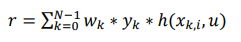



con N el número de ejemplos de entrenamiento, k el índice de estos ejemplos.


In [33]:
def choose_u(X_feature,y_label,w_vec):
    """
    X_feauters corresponde a la caracteristica i, un vector 296.
    y_label vector de 296.
    """
    r = []
    U = []
    #cada columna representa una caracteristica, por cada columna determinamos
    #un valor de r
    for k in range(X_feature.shape[1]):
        r_list = []
        u_aux = []
        X_col = X_feature[:,k]
        inicio = np.min(X_col)
        fin =  np.max(X_col)
        #10 umbrales equidistantes entre el menor y el mayor valor
        u_list = np.linspace(inicio, fin, 10)
        for u in u_list:
            ri = np.sum(w_vec*y_label*h(X_col,u))
            r_list.append(ri)
            u_aux.append(u)
        U.append( u_aux[np.argmax(r_list)] )
        r.append(r_list[np.argmax(r_list)])
    return np.array(U),np.array(r)

In [34]:
def clasificador_fit(X_feature,y,T):
    #N muestras
    #inicializamos los pesos con 1/N
    at,it,ut,hf = [], [], [], []
    N = X_feature.shape[0]
    w = np.ones(N)*(1/N)

    for t in range(T):
        w = w/np.sum(w) #normalizamos los pesos
        u,r = choose_u(X_feature,y,w)
        alpha = 0.5*np.log((1+r)/(1-r))
        #indice del máximo valor de r
        idxmax = np.argmax(r)
        rmax = np.max(r)
        at.append(0.5*np.log((1+rmax)/(1-rmax)))
        it.append(idxmax)
        ut.append(u[idxmax])

        #actualizamos los pesos
        w = w*np.exp(-alpha[idxmax]*y*h(X_feature[:,idxmax],u[idxmax]))

    return np.array(at),np.array(it),np.array(ut)

In [35]:
#Reuniendo todo en una clase Adaboost que representa al clasificador.
import numpy as np

class Adaboost:
    """
    Clasificador Adaboost, se genera a partir de clasificadores debiles.
    """
    def __init__(self):
        #iniciamos los arreglos que funcionaran como contenedores
        self.at = np.array([])
        self.it = np.array([])
        self.ut = np.array([])

    def h(x,u):
        return (x>u)*2-1

    def choose_u(X_feature,y_label,w_vec):
        """
        X_feauters corresponde a la caracteristica i, un vector 296.
        y_label vector de 296.
        """
        r = []
        U = []
        #cada columna representa una caracteristica, por cada columna determinamos
        #un valor de r
        for k in range(X_feature.shape[1]):
            r_list = []
            u_aux = []
            X_col = X_feature[:,k]
            inicio = np.min(X_col)
            fin =  np.max(X_col)
            #10 umbrales equidistantes entre el menor y el mayor valor
            u_list = np.linspace(inicio, fin, 10)
            for u in u_list:
                ri = np.sum(w_vec*y_label*h(X_col,u))
                r_list.append(ri)
                u_aux.append(u)
            U.append( u_aux[np.argmax(r_list)] )
            r.append(r_list[np.argmax(r_list)])
        return np.array(U),np.array(r)

    def fit(self,X_feature,y,T=10):
        #N muestras
        #inicializamos los pesos con 1/N
        at,it,ut,hf = [], [], [], []
        N = X_feature.shape[0]
        w = np.ones(N)*(1/N)
       
        for t in range(T):
            #w = w/np.sum(w) #normalizamos los pesos
            u,r = choose_u(X_feature,y,w)
            alpha = 0.5*np.log((1+r)/(1-r))
            #indice del máximo valor de r
            idxmax = np.argmax(r)
            rmax = np.max(r)
            at.append(0.5*np.log((1+rmax)/(1-rmax)))
            it.append(idxmax)
            ut.append(u[idxmax])

            #actualizamos los pesos
            w = w*np.exp(-alpha[idxmax]*y*h(X_feature[:,idxmax],u[idxmax]))

        self.at = np.array(at)
        self.it = np.array(it)
        self.ut = np.array(ut)

    def predict(self,X):
        """
        x corresponde al vector de caracteristicas de una imagen o de un conjunto de imagenes
        a clasificar, at los alfas calculados, it los indices de los alfas calculados y ut los 
        umbrales respectivos.

        Predice la clase para las muestras en X.
        Parameters
        ----------
        X : The data matrix for which we want to get the predictions.
        El vector o matriz de caracteristicas 

        Returns
        -------
        y_pred : ndarray of shape (n_samples,)
            Vector que contiene las clases predichas para cada ejemplo.

        """
        try:
            y_pred = []
            for x in X:
                y_pred.append(np.sign(np.sum(self.at*h(x[self.it],self.ut))))
        except IndexError:
            y_pred = np.sign(np.sum(self.at*h(X[self.it],self.ut)))
        return np.array(y_pred)

In [62]:
clasificador = Adaboost() #inicializamos el clasificador
clasificador.fit(X_train_features,y_train,T=10)  #entrenamos
y_train_pred = clasificador.predict(X_train_features) #
y_test_pred = clasificador.predict(X_test_features)

Train:
Classification accuracy is 87.837838 %
Classification recall is 87.837838 %



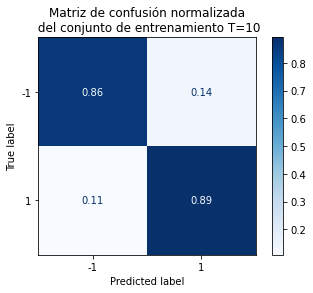

Test:
Classification accuracy is 89.189189 %
Classification recall is 89.189189 %



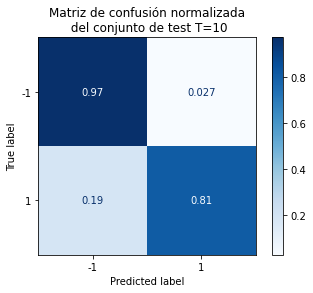

In [63]:
# calculate accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import  accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

print("Train:")
accuracy = accuracy_score(y_train, y_train_pred)*100
recall = recall_score(y_train, y_train_pred, average='macro')*100
print("Classification accuracy is %2f"%accuracy,"%")
print("Classification recall is %2f"%recall,"%\n")

cm = confusion_matrix(y_train, y_train_pred,labels=[-1,1],normalize='true')
disp =ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[-1,1])
disp.plot(cmap='Blues')
plt.title("Matriz de confusión normalizada\n del conjunto de entrenamiento T=10")
plt.show()

print("Test:")
accuracy = accuracy_score(y_test, y_test_pred)*100
recall = recall_score(y_test, y_test_pred, average='macro')*100
print("Classification accuracy is %2f"%accuracy,"%")
print("Classification recall is %2f"%recall,"%\n")

cm = confusion_matrix(y_test, y_test_pred,labels=[-1,1],normalize='true')
disp =ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[-1,1])
disp.plot(cmap='Blues')
plt.title("Matriz de confusión normalizada\n del conjunto de test T=10")
plt.show()

Tiempo de ejecución para T=5: 3.46 segundos.
Train:
Classification accuracy is 85.135135 %
Classification recall is 85.135135 %



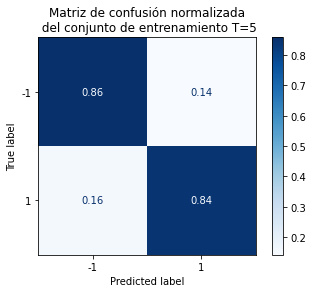

Test:
Classification accuracy is 86.486486 %
Classification recall is 86.486486 %



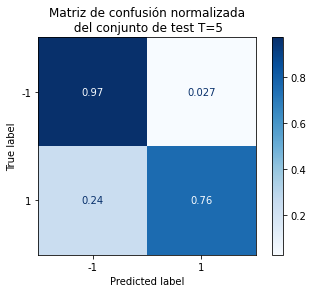

Tiempo de ejecución para T=10: 6.99 segundos.
Train:
Classification accuracy is 87.837838 %
Classification recall is 87.837838 %



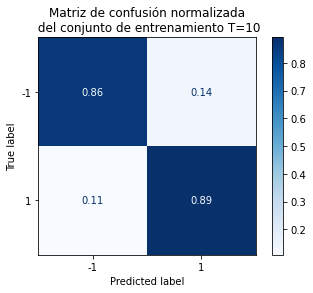

Test:
Classification accuracy is 89.189189 %
Classification recall is 89.189189 %



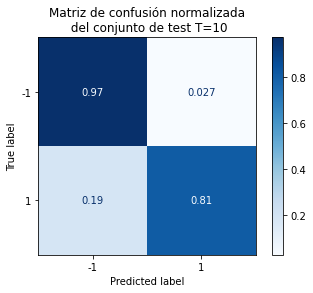

Tiempo de ejecución para T=20: 14.48 segundos.
Train:
Classification accuracy is 90.878378 %
Classification recall is 90.878378 %



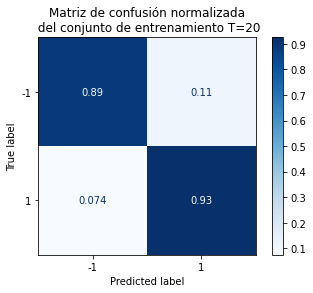

Test:
Classification accuracy is 90.540541 %
Classification recall is 90.540541 %



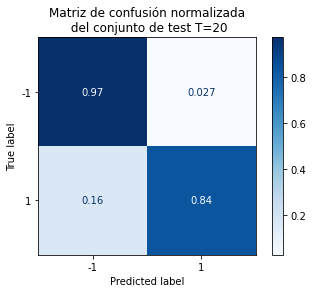

In [64]:
import time
clasificador = Adaboost()

T = [5,10,20]
for t in T:
    inicio = time.time()
    clasificador.fit(X_train_features,y_train,T=t)
    y_train_pred = clasificador.predict(X_train_features)
    y_test_pred = clasificador.predict(X_test_features)
    final = time.time()
    print(f"Tiempo de ejecución para T={t}: {round(final-inicio,2)} segundos.")

    print("Train:")
    accuracy = accuracy_score(y_train, y_train_pred)*100
    recall = recall_score(y_train, y_train_pred, average='macro')*100
    print("Classification accuracy is %2f"%accuracy,"%")
    print("Classification recall is %2f"%recall,"%\n")

    cm = confusion_matrix(y_train, y_train_pred,labels=[-1,1],normalize='true')
    disp =ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[-1,1])
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de confusión normalizada\n del conjunto de entrenamiento T={t}")
    plt.show()

    print("Test:")
    accuracy = accuracy_score(y_test, y_test_pred)*100
    recall = recall_score(y_test, y_test_pred, average='macro')*100
    print("Classification accuracy is %2f"%accuracy,"%")
    print("Classification recall is %2f"%recall,"%\n")

    cm = confusion_matrix(y_test, y_test_pred,labels=[-1,1],normalize='true')
    disp =ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[-1,1])
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de confusión normalizada\n del conjunto de test T={t}")
    plt.show()

In [69]:
clasificador = Adaboost() #inicializamos el clasificador
clasificador.fit(X_train_features,y_train,T=10)  #entrenamos
y_train_pred = clasificador.predict(X_train_features) #
y_test_pred = clasificador.predict(X_test_features)

In [70]:
p= np.array(parametros)
p[clasificador.it]

array([[18,  0, 22, 12,  1,  1],
       [ 3,  9,  7, 21,  1,  1],
       [18,  0, 22, 12,  1,  1],
       [18,  0, 22, 12,  0,  1],
       [ 6,  6, 18, 14,  0,  1],
       [15,  0, 23,  4,  0,  1],
       [ 9,  3, 17, 15,  4,  1],
       [ 3,  3,  7, 11,  1,  1],
       [ 3, 15,  7, 23,  0,  1],
       [18,  3, 22, 15,  1,  1]])

1 1 (10, 10, 255)
1 1 (10, 10, 255)
1 1 (10, 10, 255)
0 1 (0, 0, 255)
0 1 (0, 0, 255)
0 1 (0, 0, 255)
4 1 (40, 40, 255)


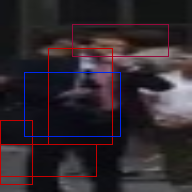

In [117]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/pedestrian/1.png')
image = cv2.resize(img, (192,192))
s=0
for y1,x1,y2,x2,tipo,polaridad in  p[clasificador.it]:
    if s<=6:    
        y1r = y1*192//24
        x1r = x1*192//24
        y2r = y2*192//24
        x2r = x2*192//24
        print(tipo,polaridad,(tipo*10,tipo*10,155+100*polaridad))
        #colores BGR
        image = cv2.rectangle(image, (x1r,y1r),(x2r,y2r),(int(60*(tipo)),int(10*(tipo)),int(150*polaridad+50*(1-tipo))),1)
    s+=1
cv2_imshow(image)


1 1 (10, 10, 255)
1 1 (10, 10, 255)
1 1 (10, 10, 255)
0 1 (0, 0, 255)
0 1 (0, 0, 255)
0 1 (0, 0, 255)
4 1 (40, 40, 255)


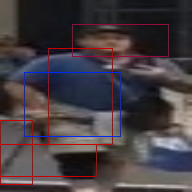

In [116]:
img = cv2.imread('/content/pedestrian/9.png')
image = cv2.resize(img, (192,192))
s=0
for y1,x1,y2,x2,tipo,polaridad in  p[clasificador.it]:
    if s<=6:    
        y1r = y1*192//24
        x1r = x1*192//24
        y2r = y2*192//24
        x2r = x2*192//24
        print(tipo,polaridad,(tipo*10,tipo*10,155+100*polaridad))
        image = cv2.rectangle(image, (x1r,y1r),(x2r,y2r),(int(60*(tipo)),int(10*(tipo)),int(150*polaridad+50*(1-tipo))),1)
    s+=1
cv2_imshow(image)

10
1 1 (60, 10, 150)
1 1 (60, 10, 150)
1 1 (60, 10, 150)
0 1 (0, 0, 200)
0 1 (0, 0, 200)
0 1 (0, 0, 200)
4 1 (240, 40, 0)


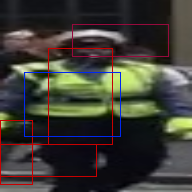

In [115]:
img = cv2.imread('/content/pedestrian/6.png')
image = cv2.resize(img, (192,192))
s=0
print(len(p[clasificador.it]))
for y1,x1,y2,x2,tipo,polaridad in  p[clasificador.it]:
    if s<=6:
        y1r = y1*192//24
        x1r = x1*192//24
        y2r = y2*192//24
        x2r = x2*192//24
        print(tipo,polaridad,(60*(tipo),10*(tipo),150*polaridad+50*(1-tipo)))
        image = cv2.rectangle(image, (x1r,y1r),(x2r,y2r),(int(60*(tipo)),int(10*(tipo)),int(150*polaridad+50*(1-tipo))),1)
    s+=1
cv2_imshow(image)